In [ ]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)
username = getpass.getpass()    # SNOWFLAKE-USERNAME
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [ ]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [ ]:
def sales_growth():
    year_df=session.sql("  select year(ORDER_TS) as years,sum(oh.order_total) \
    from FROSTBYTE_TASTY_BYTES.RAW_POS.ORDER_HEADER oh \
    join RAW_POS.LOCATION lc on oh.location_id=lc.location_id \
    where lc.iso_country_code='US'\
    group by years\
    order by years;")

    array=year_df.collect()
    year_list=[]
    yoy_list=[]
    for i in  range(1,len(array)):
        diff=array[i][1]-array[i-1][1]
        percent=(diff/array[i-1][1])*100
        year_list.append(str(array[i][0]))
        yoy_list.append(percent)
    
    plt.plot(year_list,yoy_list)
    plt.ylabel('YOY% Growth')
    plt.xlabel("Year")
    
    for i in range(len(year_list)):
        plt.annotate(f'{yoy_list[i]:.0f}%', (year_list[i], yoy_list[i]), xytext=(1, 2),
                     textcoords='offset points')

    plt.show()
    

## Overview of Solution

 Before going into the technical deatails and the other info the end goal of the solution need to identified. Based on the buisness overview they were three goals that TastyByte wanted to achieve.They are 20% YoY growth in Sales and the number of trucks for the next 5 years. Along with a improvement in NPS from 3 to 40.

 The objective that the report would aims to achieving the goal of 20%YoY growth in Sales over the next 5 years. The chart below shows the YoY sales growth over the years of the buisness operation. From the chart it can be seen that the buisness expotianal growth in its first two year which have slow down to a 30% increaase in 2022 compared to 2021. Our solution aims to stabilise the YoY growth in sales by trying to improve sales generated by each truck.

In Order to maximise sale for each of the food truck , the pain points that prevent the truck to maximise their sales has to identified. Based on data , it was discovered that the movement of truck is rather not too costly in other word it is not profitable.Another possible pain point is about truck having limited storage space which can lead to lack of customer catering. The chart below shows sales earned per km travel. The metric allows to check how profitable movement of the truck is.


Based on the chart it can be seen that the profitablity of the truck movement has been rather stagnant. The solution that would be used to solve ths problem would be optimised routing. Optimised routing would not only increase the profitability of the movement , it could be also improve customer catering. This is because each truch which serve a particual menu would be directed to a location where the items would popular among the demographics there.

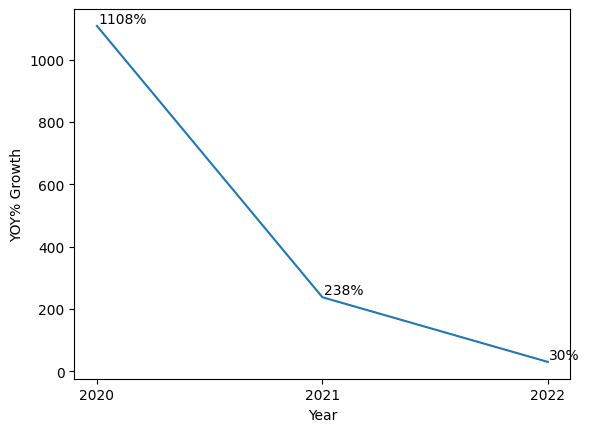

In [ ]:

sales_growth()

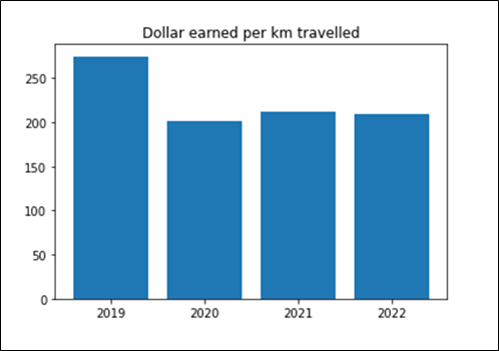

In [1]:
from IPython.display import Image, display
display(Image(filename='Picture1.png'))

# Transformation and Filtering

### Filter

We would be building a prototype for our model. As it is prototype, we do not want to use all the data as it would utilise too much computing resources and time , hence we are filtering it down to just united states which is the region with the highest number of sales.

In [ ]:
sdf = session.table('ANALYTICS.ORDERS_V')
df=sdf.filter(col("COUNTRY")=='United States')

In [ ]:
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"E_MAIL"  |"PHONE_NUMBER"  |"CHILDREN_COUNT"  |"GENDER"  |"MARITAL_STATUS"  |"MENU_ITEM_ID"  |"MENU_ITEM_NAME"   

In [ ]:
df=df.drop(['ORDER_DISCOUNT_AMOUNT','ORDER_TAX_AMOUNT','ORDER_AMOUNT','PRICE','UNIT_PRICE','QUANTITY','MENU_ITEM_NAME','MENU_ITEM_ID','MARITAL_STATUS','GENDER','CHILDREN_COUNT','PHONE_NUMBER','E_MAIL','LAST_NAME','FIRST_NAME','CUSTOMER_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','FRANCHISE_ID','FRANCHISE_FLAG','LINE_NUMBER','ORDER_ID'])

### Extract weather data

We would be first extracting weather data and then converted it into pandas. We would be using it later.

In [ ]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [ ]:
wdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
wdf2 = wdf.to_pandas()

In [ ]:
wdf2.head()

,POSTAL_CODE,COUNTRY,DATE_VALID_STD,DOY_STD,MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,MIN_TEMPERATURE_WETBULB_2M_F,AVG_TEMPERATURE_WETBULB_2M_F,MAX_TEMPERATURE_WETBULB_2M_F,...,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,TOT_SNOWDEPTH_IN,MIN_CLOUD_COVER_TOT_PCT,AVG_CLOUD_COVER_TOT_PCT,MAX_CLOUD_COVER_TOT_PCT,MIN_RADIATION_SOLAR_TOTAL_WPM2,AVG_RADIATION_SOLAR_TOTAL_WPM2,MAX_RADIATION_SOLAR_TOTAL_WPM2,TOT_RADIATION_SOLAR_TOTAL_WPM2
0,102103,NG,2021-08-19,231,73.7,77.4,84.6,72.5,73.6,75.1,...,0.16,0.0,0.0,20,88,100,0.0,149.9,668.7,3596.4
1,110054,IN,2021-08-19,231,76.9,87.4,100.1,73.2,76.8,80.9,...,0.01,0.0,0.0,37,77,100,0.0,269.6,927.2,6470.4
2,2044,AU,2021-08-19,231,49.4,59.3,67.4,48.0,53.0,56.3,...,0.00,0.0,0.0,3,46,96,0.0,167.1,688.0,4010.1
3,21745-690,BR,2021-08-19,231,65.7,74.0,86.1,63.6,66.9,71.8,...,0.00,0.0,0.0,0,2,7,0.0,235.5,822.0,5651.3
4,60596,DE,2021-08-19,231,57.9,62.7,66.3,57.2,60.3,62.6,...,0.03,0.0,0.0,75,97,100,0.0,59.9,196.1,1438.4


## Creating DateTime Variables

We converted the order_timestamp columns into something that is more managable. The first step is to create new columns for month day and hour. This is to allow the model to discover relationship between the target columns and the individual aspects of dates more easily. The second part is to create column for day of week and week of month. This is cause it may effect sales. e.g there could be sales on the weekend or more sales on the first after people reacieve their salary.

In [ ]:
df=df.withColumn("Month",F.month(df["ORDER_TS"]))
df=df.withColumn("DOW",F.dayofweek(df["ORDER_TS"]))
df=df.withColumn("Day",F.dayofmonth(df["ORDER_TS"]))
df=df.withColumn("Hour",F.hour(df["ORDER_TS"]))
df=df.withColumn("WOM", ((F.dayofmonth(F.col('ORDER_TS')) - 1) / 7 + 1).cast('integer'))

In [ ]:
# Create public holiday column binary
public_holidays = [
    {'Month': 7, 'Day': 4, 'DOW': None, 'WOM': None},  # 4th of July
    {'Month': 12, 'Day': 24, 'DOW': None, 'WOM': None},  # Christmas Eve
    {'Month': 12, 'Day': 25, 'DOW': None, 'WOM': None},  # Christmas Day
    {'Month': 10, 'Day': None, 'DOW': '1', 'WOM': 2},  # Columbus Day (second Monday in October)
    {'Month': 6, 'Day': 19, 'DOW': None, 'WOM': None},  # Juneteenth
    {'Month': 9, 'Day': None, 'DOW': '1', 'WOM': 1},  # Labor Day (first Monday in September)
    {'Month': 1, 'Day': None, 'DOW': '1', 'WOM': 3},  # Martin Luther King, Jr. Day (third Monday in January)
    {'Month': 5, 'Day': None, 'DOW': '1', 'WOM': -1},  # Memorial Day (last Monday in May)
    {'Month': 1, 'Day': 1, 'DOW': None, 'WOM': None},  # New Year's Day
    {'Month': 12, 'Day': 31, 'DOW': None, 'WOM': None},  # New Year's Eve
    {'Month': 11, 'Day': None, 'DOW': '4', 'WOM': 4},  # Thanksgiving Day (fourth Thursday in November)
    {'Month': 11, 'Day': None, 'DOW': '3', 'WOM': 4},  # Thanksgiving Eve (fourth Wednesday in November)
    {'Month': 2, 'Day': 14, 'DOW': None, 'WOM': None},  # Valentine's Day
    {'Month': 11, 'Day': 11, 'DOW': None, 'WOM': None},  # Veterans Day
    {'Month': 10, 'Day': 31, 'DOW': None, 'WOM': None},  # Halloween
    {'Month': 3, 'Day': 17, 'DOW': None, 'WOM': None},  # St. Patrick's Day
    {'Month': 11, 'Day': 25, 'DOW': '5', 'WOM': None},  # Black Friday
    {'Month': 12, 'Day': 26, 'DOW': None, 'WOM': None},  # Boxing Day
]

In [ ]:
from snowflake.snowpark.types import IntegerType
from snowflake.snowpark.functions import col, when

# Initialize the 'PUBLIC_HOLIDAY' column to 0
df = df.withColumn('PUBLIC_HOLIDAY', F.lit(0))

# Iterate through the public_holidays list and update the 'PUBLIC_HOLIDAY' column
for h in public_holidays:
    df = df.withColumn(
        'PUBLIC_HOLIDAY',
        when(
            (F.month(F.col('DATE')) == h['Month']) &
            (F.dayofweek(F.col('DATE')) == h['DOW'] if h['DOW'] is not None else True) &
            (((F.col('Day') - 1) / 7 + 1).cast('integer') == h['WOM'] if h['WOM'] is not None else True) &
            (F.dayofmonth(F.col('DATE')) == h['Day'] if h['Day'] is not None else True),
            1
        ).otherwise(F.col('PUBLIC_HOLIDAY')))

## Grouping

The code below basically aggregates the order_total column(the sales amount) together based on the other features. It basically gives sales for each truck for each hour.

In [ ]:
df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"LOCATION_ID"  |"ORDER_TOTAL"  |"MONTH"  |"DOW"  |"DAY"  |"HOUR"  |"WOM"  |"PUBLIC_HOLIDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-05-07  |17          |2022-05-07 19:03:36  |883147696          |Smoky BBQ           |BBQ          |Denver          |Colorado  |United States  |5112           |94.0000        |5        |6      |7      |19      |2      |0                 |
|2022-05-07  |17          |2

In [ ]:
grouped_df = df.groupBy("DATE","TRUCK_ID","MONTH","HOUR","DOW","DAY","Menu_Type","LOCATION_ID","PUBLIC_HOLIDAY").agg(F.sum("ORDER_TOTAL"))

## Joining with weather data

To join the weather data with the aggregated data, both of the data need to be inside the same snowpark dataframe. So we would be converting the weather data to pandas and then upload to Frostbyte dataframe. After that the grouped dataframe was joined with a new location table created by us which basically include data about the postalcode for the location. The postalcode would then be used to merge with the weather data(using zip code). The table created would be then be posted in to snowflake.

In [ ]:
grouped_df.count()

645365

In [ ]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "GLOBAL_WEATHER__CLIMATE_DATA_FOR_BI",

    "warehouse": "HOL_WH"
}

wea_session = Session.builder.configs(connection_parameters).create()
wdf = wea_session.table('STANDARD_TILE.HISTORY_DAY')

In [ ]:
wdf=wea_session.sql("select * From STANDARD_TILE.HISTORY_DAY")

In [ ]:
grouped_df.show()

-------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |
-------------------------------------------------------------------------------------------------------------------------------------
|2022-02-05  |64          |2        |12      |6      |5      |Mac & Cheese  |8426           |0                 |15915.0000          |
|2022-02-05  |62          |2        |22      |6      |5      |BBQ           |4111           |0                 |16756.0000          |
|2022-02-05  |64          |2        |15      |6      |5      |Mac & Cheese  |15175          |0                 |17781.0000          |
|2022-02-05  |65          |2        |9       |6      |5      |Ramen         |15126          |0                 |23047.2500          |
|2022-02-05  |65          |2        |15      |6      |5      |

In [ ]:
wdf_re=wdf.with_column_renamed(col("DATE_VALID_STD"), "DATE")

In [ ]:
sdf_loc = session.table('RAW_POS.Location_New')

In [ ]:
sdf_loc_dr=sdf_loc.drop("PLACEKEY","ISO_COUNTRY_CODE")

In [ ]:
sdf_loc_dr.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"LOCATION"                                        |"CITY"  |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"               |"ZIPCODE"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|1030           |University Of Colorado Museum Of Natural History  |Denver  |CO        |United States  |40.00768674326263   |-105.26970066129032  |80802      |
|1031           |Denver Technological Center                       |Denver  |CO        |United States  |39.62735682905758   |-104.91269066527825  |80237      |
|1032           |Heritage Club At Denver Tech Center               |Denver  |CO        |United States  |39.62526657316754   |-104.91238594440485  |80237      |
|1033           |Porter Wound Care Cente

In [ ]:
semi_final_df=grouped_df.join(sdf_loc_dr, grouped_df["LOCATION_ID"] == sdf_loc_dr["LOCATION_ID"])

In [ ]:
# # # # weather=wdf_re.to_pandas()
# weather=wdf_re.to_pandas()
# syntax=pd.io.sql.get_schema(weather, "weather_data")
# session.use_schema("ANALYTICS")
# session.sql(
    
#     syntax
# ).collect()
# session.write_pandas(
#     df=weather,
#     table_name="weather_data",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [ ]:
semi_final_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"     |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_ipsj_LOCATION_ID"  |"LOCATION"                             |"CITY"  |"REGION"  |"COUNTRY"      |"LAT"               |"LONG"               |"ZIPCODE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2022-05-07  |17          |5        |19      |6      |7      |BBQ             |5112                  |0      

In [ ]:
semi_final_df=semi_final_df.with_column_renamed(col("ZIPCODE"), "POSTAL_CODE")

In [ ]:
grp=semi_final_df.to_pandas()

In [ ]:
wdf = session.table('RAW_POS.weather_data')
wdf=wdf.select("POSTAL_CODE","DATE","COUNTRY","AVG_TEMPERATURE_AIR_2M_F","AVG_TEMPERATURE_HEATINDEX_2M_F","TOT_PRECIPITATION_IN","TOT_SNOWFALL_IN","TOT_SNOWDEPTH_IN","AVG_CLOUD_COVER_TOT_PCT")

In [ ]:
final_df = semi_final_df.join(wdf, (semi_final_df["DATE"] == wdf["DATE"]) & (semi_final_df["POSTAL_CODE"] == wdf["POSTAL_CODE"]),join_type="left")

In [ ]:
final_df

In [ ]:
final_df.count()

In [ ]:
session.use_schema("ANALYTICS")
final_df.write.save_as_table(table_name="sales_prediction", mode='overwrite')

## Merging

Next we would be prediction with the sales prediction table , which contain useful data about sales of each meny type by city and so on. By utlising this info we would be able to merge with .

In [ ]:
to_encode_df = session.table('ANALYTICS.SALES_PREDICTION')

In [ ]:
to_encode_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"r_ipsj_LOCATION_ID"  |"LOCATION"         |"CITY"         |"REGION"  |"l_99ts_COUNTRY"  |"LAT"               |"LONG"               |"l_99ts_POSTAL_CODE"  |"r_dmty_POSTAL_CODE"  |"r_dmty_DATE"  |"r_dmty_COUNTRY"  |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"

In [ ]:
columns_to_drop = ['"r_ipsj_LOCATION_ID"','"l_99ts_COUNTRY"','"l_99ts_POSTAL_CODE"','"r_dmty_POSTAL_CODE"','"r_dmty_COUNTRY"','"r_dmty_DATE"'] #'r_ipsj' keys changes everytime file is run
new_columns  = [c for c in to_encode_df.columns if c not in columns_to_drop]
dropped_df = to_encode_df.select(*new_columns)

In [ ]:
dropped_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"       |"CITY"   |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
to_encode_df.count()

645365

In [ ]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTE",

    "warehouse": "HOL_WH"
}

nt_session = Session.builder.configs(connection_parameters).create()
sales = nt_session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_Base")

In [ ]:
sales.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import decimal 

In [ ]:
decimal.getcontext().prec=2

In [ ]:
merge_df=nt_session.sql("""SELECT
DATE,
  LOCATION_ID,
  MENU_TYPE,
  SUM(DAY_OF_WEEK_AVG_CITY_MENU_TYPE) AS SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,
  SUM(PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE) AS SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
FROM ANALYTICS.DEMAND_FORECAST_TRAINING_Base
GROUP BY DATE, LOCATION_ID, MENU_TYPE""")

In [ ]:
mdf=merge_df.to_pandas()

In [ ]:
# syntax=pd.io.sql.get_schema(mdf, "DEMAND_FORECAST_TRAINING_Base")
# session.use_schema("ANALYTICS")
# session.sql(

#     syntax
# ).collect()
# session.write_pandas(
#     df=mdf,
#     table_name="DEMAND_FORECAST_TRAINING_Base",
#     database="frostbyte_tasty_bytes",
#     schema="ANALYTICS",
#     quote_identifiers=False,
#     overwrite=True)

In [ ]:
mdf=session.sql("Select * from ANALYTICS.DEMAND_FORECAST_TRAINING_BASE")

In [ ]:
mdf.show()

--------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------------------------------------------------------------
|2022-07-27  |12599          |Ice Cream    |1.2E+4                                |NULL                                        |
|2020-07-02  |2935           |Sandwiches   |4.1E+3                                |NULL                                        |
|2022-01-05  |15485          |Ramen        |8.9E+3                                |1.6E+6                                      |
|2022-02-26  |3821           |Gyros        |2.9E+4                                |NULL                                        |
|2021-09-25  |3722           |Crepes       |2.9E+4                                |NULL          

In [ ]:
mdf.where(col("SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE").isNull()).count()

283962

In [ ]:
mdf.count()

510890

In [ ]:
mdf.show()

--------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"LOCATION_ID"  |"MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------------------------------------------------------------------------------------------------------
|2022-07-27  |12599          |Ice Cream    |1.2E+4                                |NULL                                        |
|2020-07-02  |2935           |Sandwiches   |4.1E+3                                |NULL                                        |
|2022-01-05  |15485          |Ramen        |8.9E+3                                |1.6E+6                                      |
|2022-02-26  |3821           |Gyros        |2.9E+4                                |NULL                                        |
|2021-09-25  |3722           |Crepes       |2.9E+4                                |NULL          

In [ ]:
dropped_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"l_99ts_DATE"  |"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"   |"l_3iuv_LOCATION_ID"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"       |"CITY"   |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
merge_df=dropped_df.join(mdf, (dropped_df['"l_99ts_DATE"'] == mdf["DATE"])& (dropped_df['"MENU_TYPE"'] == mdf["MENU_TYPE"])& (dropped_df['"l_3iuv_LOCATION_ID"'] == mdf["Location_ID"])).drop('"l_99ts_DATE"').drop('"l_3iuv_LOCATION_ID"')

In [ ]:
merge_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"l_lax9_MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                                     |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"r_kyjx_MENU_TYPE"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM

In [ ]:
merge_df = merge_df.withColumnRenamed('"l_lax9_MENU_TYPE"','Menu_Type')
merge_df=merge_df.drop('"r_kyjx_MENU_TYPE"')

In [ ]:
merge_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                                     |"CITY"         |"REGION"  |"LAT"               |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------

# Data Wrangling

### Null Encoding

As can be seen the weather data is largely null(total data:64k+), hence making it largely usless. Hence , we decide to utilise an api for the weather data and delete the pre-existing data for weather.

In [ ]:
for i in ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']:
    print(i,merge_df.where(col(i).isNull()).count())

AVG_TEMPERATURE_AIR_2M_F 641821
AVG_TEMPERATURE_HEATINDEX_2M_F 641821
TOT_PRECIPITATION_IN 641821
TOT_SNOWFALL_IN 641821
TOT_SNOWDEPTH_IN 641821
AVG_CLOUD_COVER_TOT_PCT 641821


#### API CODE

In [ ]:
## Creating df with only the location details and the date.
merge_df_pandas=merge_df.to_pandas()
loc_checker=merge_df_pandas[["LAT","LONG","DATE","LOCATION_ID"]]

In [ ]:
import requests
merge_df.count()
merge_df_pandas=merge_df.to_pandas()
loc_checker=merge_df_pandas[["LAT","LONG","DATE","LOCATION_ID"]]
#function returns df with all the unique location with weather for each date.
def check_postal_codes(df):
    #Create a df for each location providing the rain data from the start date till the end date. The df would then be appended together
    api_url = "https://archive-api.open-meteo.com/v1/archive"
    no=0
    
    ## ALL neccesary parameters
    parameter = "weathercode"

    start_date = df["DATE"].min()
    end_date = df["DATE"].max()
    #create list with unique locations.
    data_list=list(df.drop_duplicates(subset=["LAT","LONG"]).values)
    
    
    ## create the intial dataframe to which other df would be appended to
    latitude=data_list[0][0]
    longitude=data_list[0][1]
    url = f"{api_url}?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={parameter}"
    response = requests.get(url)
    temp_dict=response.json()["hourly"]
    
    location_data = data_list[0][3]
    

    location_list = [location_data  for value in response.json()["hourly"]["time"]]
    
    temp_dict["Location_Id"]=location_list
    final_df = pd.DataFrame(temp_dict)
    
    for  row in   data_list:
        no+=1
        
        latitude = row[0]
        longitude = row[1]
        # create the url to get response for each row of unique location
        url = f"{api_url}?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={parameter}"
        
        location_data=row[3]
        response = requests.get(url)

        if response.status_code != 200:
            
             print(f"Postal code {location_data} did not return a valid response.")
         
        #collect reponse and convert it to pandas and append to inital df.
        temp_dict=response.json()["hourly"]
        location_list = [location_data  for value in response.json()["hourly"]["time"]]
    
        temp_dict["Location_Id"]=location_list
        temp_df= pd.DataFrame(temp_dict)
        final_df=pd.concat([final_df, temp_df], ignore_index=True)   
       
    return final_df

res=check_postal_codes(loc_checker)

In [ ]:
## write it to frostbyte database so it can be merger
session.write_pandas(
    df=res,
    table_name="Weather_DATA_API",
    database="frostbyte_tasty_bytes",
    schema="ANALYTICS",
    quote_identifiers=False,
    overwrite=True)

In [ ]:
merge_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"                             |"CITY"         |"REGION"  |"LAT"              |"LONG"               |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"DATE"      |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |
--------------------------------

In [ ]:
##drop all columns
columns_to_drop=["AVG_TEMPERATURE_AIR_2M_F","AVG_TEMPERATURE_HEATINDEX_2M_F","TOT_PRECIPITATION_IN","TOT_SNOWFALL_IN" ,"TOT_SNOWDEPTH_IN" ,"AVG_CLOUD_COVER_TOT_PCT" ]
new_columns  = [c for c in merge_df.columns if c not in columns_to_drop]
merge_df = merge_df.select(*new_columns)

In [ ]:
wdf=session.sql("Select * from ANALYTICS.WEATHER_DATA_API")

In [ ]:
wdf=wdf.withColumn("H",F.substring(wdf["TIME"], 12, 2).cast("integer"))
wdf=wdf.withColumn("DATE",F.substring(wdf["TIME"], 0, 10))

In [ ]:
wdf=wdf.select("WEATHERCODE","LOCATION_ID","H","DATE" )

In [ ]:
##merging based on date, location and hour.
merge_df_api=merge_df.join(wdf,(merge_df["DATE"]==wdf["DATE"])&(merge_df["LOCATION_ID"]==wdf["LOCATION_ID"])&(merge_df["HOUR"]==wdf["H"]),join_type="inner")

In [ ]:
#cleaning the merge
merge_df_api=merge_df_api.drop('"l_p304_DATE"').drop('"H"' ).drop('"r_05dn_DATE"').drop('"r_05dn_LOCATION_ID"')

In [ ]:
merge_df_api.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"        |"CITY"  |"REGION"  |"LAT"              |"LONG"             |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|47          |3        |15      |0      |13     |BBQ          |0                 |5.5E+3              |

In [ ]:
merge_df_api=merge_df_api.withColumnRenamed('"l_p304_LOCATION_ID"',"Location_id")

In [ ]:
merge_df_api.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"        |"CITY"  |"REGION"  |"LAT"              |"LONG"             |"AVG_TEMPERATURE_AIR_2M_F"  |"AVG_TEMPERATURE_HEATINDEX_2M_F"  |"TOT_PRECIPITATION_IN"  |"TOT_SNOWFALL_IN"  |"TOT_SNOWDEPTH_IN"  |"AVG_CLOUD_COVER_TOT_PCT"  |"l_p304_DATE"  |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |"r_05dn_LOCATION

#### Null encoding 2.0

In [ ]:
##check for null values, return the number of null and provide the median value for imputation
nullColumns = []
numRows = merge_df_api.count()
for k in merge_df_api.columns:
    
    nullRows = merge_df_api.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(merge_df_api.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 284668, [1555034.3240003583]],
 ['WEATHERCODE', 0]]

In [ ]:

dropped_df=merge_df_api.na.fill({ 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE':decimal.Decimal(1459187.6660313606)})

In [ ]:
nullColumns = []
numRows = dropped_df.count()
for k in dropped_df.columns:
    
    nullRows = dropped_df.where(col(k).isNull()).count()
    columns=[k,nullRows]
    if nullRows>0:
        columns.append(dropped_df.stat.approxQuantile(k,[0.5]))
    nullColumns.append(columns)

nullColumns
# ['D']

[['TRUCK_ID', 0],
 ['MONTH', 0],
 ['HOUR', 0],
 ['DOW', 0],
 ['DAY', 0],
 ['MENU_TYPE', 0],
 ['PUBLIC_HOLIDAY', 0],
 ['"SUM(ORDER_TOTAL)"', 0],
 ['LOCATION', 0],
 ['CITY', 0],
 ['REGION', 0],
 ['LAT', 0],
 ['LONG', 0],
 ['LOCATION_ID', 0],
 ['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 0],
 ['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 0],
 ['WEATHERCODE', 0]]

In [ ]:
dropped_df=dropped_df.drop("DATE")


### Encoding

All the categorical columns with exception for locations(which would be represented location id) would be one hot encoded. The reason being is to prevent the model from assuming any kind of linear relation between the target columns and the categorical columns. However this was not done for location and truck id due to it sheer amount.

In [ ]:
def one_hot_encode_columns(df, column_names):
    encoded_df = df
    
    for column_name in column_names:
        unique_values = [row[column_name] for row in df.select(column_name).distinct().collect()]
        
        # Create a new column for each unique value and perform one-hot encoding
        for value in unique_values:
            encoded_column_name = f"{column_name}_{value}_encoded"
            encoded_df = encoded_df.withColumn(encoded_column_name, F.when(F.col(column_name) == value, 1).otherwise(0))
    
    
    return encoded_df
dropped_df.select("menu_type").distinct().show()dropped_df.show()

columns = dropped_df.columns

# Iterate over the columns and count the number of unique values
unique_counts = {}
for column in columns:
    unique_counts[column] = dropped_df.select(column).distinct().count()

# Print the unique counts for each column
for column, count in unique_counts.items():
    print(f"Column '{column}': {count}")

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"MENU_TYPE"  |"PUBLIC_HOLIDAY"  |"SUM(ORDER_TOTAL)"  |"LOCATION"  |"CITY"         |"REGION"  |"LAT"              |"LONG"            |"LOCATION_ID"  |"SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE"  |"SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE"  |"WEATHERCODE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|68          |7        |8       |6      |10     |Crepes       |0                 |1.0E+4              |

In [ ]:
categoricalColumns = ['MENU_TYPE', 'CITY', 'REGION']

In [ ]:
encoded_df = one_hot_encode_columns(dropped_df, categoricalColumns)

In [ ]:
final_df = encoded_df.drop(*categoricalColumns)
final_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |

In [ ]:
X_final=final_df
X_final=X_final.drop("LOCATION")
X_final.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"PU

In [ ]:
session.use_schema("ANALYTICS")
X_final.write.save_as_table(table_name="Encoded_Data", mode='overwrite')
X_final.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MONTH"  |"HOUR"  |"DOW"  |"DAY"  |"PU

In [ ]:
X_final=X_final.to_pandas()

## Scaling

The numeric columns would be scaled to reduce the impact of outliers and reduce all the data to the same range.

In [ ]:
columns_not_to_scale=["TRUCK_ID","MONTH","HOUR","DOW","DAY","PUBLIC_HOLIDAY","LOCATION_ID","LAT","LONG","SUM(ORDER_TOTAL)"]     

cat_col = [i for i in X_final.columns if i not in columns_not_to_scale and  (i[:4] not in ["CITY","REGI","MENU"])]

cat_col.remove("WEATHERCODE")

In [ ]:
from sklearn.preprocessing import StandardScaler
X_final_scaled=X_final.copy()
X_final_scaled[cat_col] = StandardScaler().fit_transform(X_final[cat_col])

In [ ]:
y_final=final_df[['SUM(ORDER_TOTAL)']]
y_final=y_final.to_pandas()
y_final=pd.DataFrame(y_final,columns=y_final.columns)

In [ ]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,SUM(ORDER_TOTAL),LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
X_final_scaled["WEATHERCODE"]

0         0
1         0
2         0
3         0
4         1
         ..
540196    0
540197    0
540198    0
540199    0
540200    0
Name: WEATHERCODE, Length: 540201, dtype: int8

In [ ]:
import math
X_final_scaled.rename(columns={"SUM(ORDER_TOTAL)": "Revenue"},inplace=True)

In [ ]:
session.write_pandas(
    df=X_final_scaled,
    table_name="Sales_Forecast_Training_Data",
    database="FROSTBYTE_TASTY_BYTES",
    schema="ANALYTICS",
    quote_identifiers=True,
    overwrite=True
)


# Machine Learning Modelling

In [ ]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

In [ ]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Profit                                    540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

In [ ]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
print(X_final_scaled.columns.tolist())

['TRUCK_ID', 'MONTH', 'HOUR', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'Profit', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Revenue",axis=1)
y = X_final_scaled["Revenue"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import scipy.stats as stats

In [ ]:
X_holdout

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
58027,50,5,10,1,9,0,42.247702,-71.129438,15284,-0.372952,...,0,0,0,0,1,0,1,0,0,0
386383,33,3,10,3,16,0,47.605014,-122.336302,1675,-0.502516,...,1,0,0,0,0,0,0,0,1,0
211458,45,7,17,5,1,0,47.588769,-122.380905,15088,-0.269006,...,1,0,0,0,0,0,0,0,1,0
455709,75,11,18,6,13,0,40.710351,-74.010756,4135,1.826272,...,0,0,0,1,0,1,0,0,0,0
342396,42,5,11,6,14,0,47.575333,-122.416758,5173,-0.172671,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209115,20,3,11,1,21,0,39.750623,-105.005176,14950,-0.214759,...,0,1,0,0,0,0,0,1,0,0
510853,3,10,13,5,7,0,37.557758,-122.301884,3018,-0.980229,...,0,0,1,0,0,0,0,0,0,1
199755,41,10,9,6,23,0,47.628276,-122.358651,15030,-0.250186,...,1,0,0,0,0,0,0,0,1,0
330459,33,8,17,2,31,0,47.526835,-122.331215,1917,-0.329186,...,1,0,0,0,0,0,0,0,1,0


## LightGBM Baseline

In [ ]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

LGBMRegressor()

## XGB Model

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## RandomForestRegressor Model

In [ ]:
from sklearn. ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

## AdaBoostRegressor Model

In [ ]:
from sklearn. ensemble import AdaBoostRegressor
ab=AdaBoostRegressor()
ab.fit(X_train,y_train)
print('Train MSE is: ', mean_squared_error(ab.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(ab.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(ab.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(ab.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(ab.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(ab.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(ab.predict(X_train), y_train))
print('Test R2 is: ', r2_score(ab.predict(X_test), y_test))

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr = gbr.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(gbr.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(gbr.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(gbr.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(gbr.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(gbr.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(gbr.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(gbr.predict(X_train), y_train))
print('Test R2 is: ', r2_score(gbr.predict(X_test), y_test))

## Fine-tuned XGBoost

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
xgb = LGBMRegressor(n_estimators=500)
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

c:\Users\Nathan\anaconda3\envs\py38_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Train MSE is:  2968953.909487875
Test MSE is:  3260824.369489615

Train RMSE is:  1723.065265591491
Test RMSE is:  1805.7752821128145

Train MAE is:  1163.5308455133852
Test MAE is:  1198.4530543854682

Train R2 is:  0.9071514900595083
Test R2 is:  0.8982355271341209


In [ ]:
# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)

        TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY        LAT  \
58027         50      5    10    1    9               0  42.247702   
386383        33      3    10    3   16               0  47.605014   
211458        45      7    17    5    1               0  47.588769   
455709        75     11    18    6   13               0  40.710351   
342396        42      5    11    6   14               0  47.575333   
...          ...    ...   ...  ...  ...             ...        ...   
209115        20      3    11    1   21               0  39.750623   
510853         3     10    13    5    7               0  37.557758   
199755        41     10     9    6   23               0  47.628276   
330459        33      8    17    2   31               0  47.526835   
256006        50     11    19    0    8               0  42.303791   

              LONG  LOCATION_ID  SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE  ...  \
58027   -71.129438        15284                           -0.372952  ...   
386383 

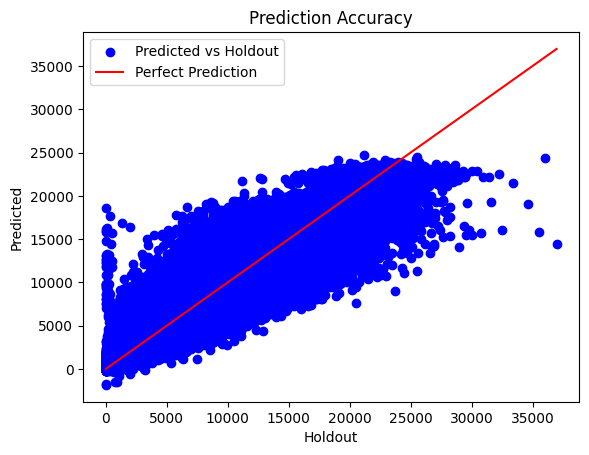

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Routing Build

In [ ]:
# Get unique location IDs
unique_location_ids = X_final_scaled['LOCATION_ID'].unique()
print("Unique Location IDs:", unique_location_ids)

# Create a list to store the table data
table_data = []


# Create a DataFrame to store the table data
df_unique_locations_lat_long = pd.DataFrame(columns=["Location ID", "Latitude", "Longitude"])

# Iterate over each unique location ID
for location_id in unique_location_ids:
    location = X_final_scaled[X_final_scaled['LOCATION_ID'] == location_id]
    latitude = location['LAT'].values[0]
    longitude = location['LONG'].values[0]
    df_unique_locations_lat_long = pd.concat([df_unique_locations_lat_long, pd.DataFrame({"Location ID": [location_id],
                                                  "Latitude": [latitude],
                                                  "Longitude": [longitude]})],
                         ignore_index=True)

# Print the DataFrame
df_unique_locations_lat_long

Unique Location IDs: [ 3007  1606 15490 ...  4029 15332  2558]


,Location ID,Latitude,Longitude
0,3007,40.768807,-73.985856
1,1606,42.344888,-71.031757
2,15490,42.367153,-71.056455
3,3757,42.366770,-71.054887
4,1149,42.335266,-71.072024
...,...,...,...
1873,4117,37.568620,-122.325058
1874,15389,42.308397,-71.063827
1875,4029,42.362159,-71.058150
1876,15332,42.362928,-71.056870


### User Input

In [ ]:
from datetime import datetime

truck_id = 43
date = '2020-8-25'
datetime_object = datetime.strptime(date, '%Y-%m-%d')
starting_hour = 15
ending_hour = 21
num_of_locs = 2
each_location_travel_distance = 8 #km
max_total_travel_distance= each_location_travel_distance * num_of_locs

In [ ]:
df = pd.DataFrame({'TRUCK_ID': [truck_id],
                   'date': [date]})

#seperate date into month, dow, day, public_holiday
df['date'] = pd.to_datetime(df['date'])
df['MONTH'] = df['date'].dt.month
df['DOW'] = df['date'].dt.weekday
df['DAY'] = df['date'].dt.day
df['WOM'] = (df['DAY'] - 1) // 7 + 1

public_holidays = [
     {'Month': 7, 'Day': 4, 'DOW': None, 'WOM': None},  # 4th of July
   {'Month': 12, 'Day': 24, 'DOW': None, 'WOM': None},  # Christmas Eve
    {'Month': 12, 'Day': 25, 'DOW': None, 'WOM': None},  # Christmas Day
    {'Month': 10, 'Day': None, 'DOW': '0', 'WOM': 2},  # Columbus Day (second Monday in October)
    {'Month': 6, 'Day': 19, 'DOW': None, 'WOM': None},  # Juneteenth
    {'Month': 9, 'Day': None, 'DOW': '0', 'WOM': 1},  # Labor Day (first Monday in September)
    {'Month': 1, 'Day': None, 'DOW': '0', 'WOM': 3},  # Martin Luther King, Jr. Day (third Monday in January)
    {'Month': 5, 'Day': None, 'DOW': '0', 'WOM': -1},  # Memorial Day (last Monday in May)
    {'Month': 1, 'Day': 1, 'DOW': None, 'WOM': None},  # New Year's Day
    {'Month': 12, 'Day': 31, 'DOW': None, 'WOM': None},  # New Year's Eve
    {'Month': 11, 'Day': None, 'DOW': '3', 'WOM': 4},  # Thanksgiving Day (fourth Thursday in November)
    {'Month': 11, 'Day': None, 'DOW': '2', 'WOM': 4},  # Thanksgiving Eve (fourth Wednesday in November)
    {'Month': 2, 'Day': 14, 'DOW': None, 'WOM': None},  # Valentine's Day
    {'Month': 11, 'Day': 11, 'DOW': None, 'WOM': None},  # Veterans Day
    {'Month': 10, 'Day': 31, 'DOW': None, 'WOM': None},  # Halloween
    {'Month': 3, 'Day': 17, 'DOW': None, 'WOM': None},  # St. Patrick's Day
    {'Month': 11, 'Day': 25, 'DOW': '4', 'WOM': None},  # Black Friday
    {'Month': 12, 'Day': 26, 'DOW': None, 'WOM': None},  # Boxing Day
]

# Iterate over the public holidays and create the 'public_holiday' column
df['PUBLIC_HOLIDAY'] = 0  # Initialize the column with 0 (not a public holiday)
for holiday in public_holidays:
    month_mask = df['date'].dt.month == holiday['Month']
    day_mask = df['date'].dt.day == holiday['Day']
    dow_mask = df['date'].dt.dayofweek == int(holiday['DOW']) if holiday['DOW'] is not None else True
    wom_mask = (df['date'].dt.day - 1) // 7 + 1 == holiday['WOM'] if holiday['WOM'] is not None else True

    mask = month_mask & day_mask & dow_mask & wom_mask
    df.loc[mask, 'PUBLIC_HOLIDAY'] = 1

df.head()

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY
0,43,2020-08-25,8,1,25,4,0


In [ ]:
#schema get Truck table + Location table, get location id, City + region
session.use_schema("RAW_POS")
query = "SELECT * FROM TRUCK WHERE TRUCK_ID = '{}'".format(truck_id)
truck_df=session.sql(query).toPandas()
#truck_df = truck_df[truck_df['TRUCK_ID']==truck_id]
city = truck_df['PRIMARY_CITY'].iloc[0]

query = "SELECT * FROM LOCATION WHERE CITY = '{}'".format(city)
location_df=session.sql(query).toPandas()
#location_df = location_df[location_df['CITY']==city]
city_locations = location_df.merge(df_unique_locations_lat_long, left_on='LOCATION_ID', right_on='Location ID', how='inner')
city_locations = city_locations[['LOCATION_ID','Latitude','Longitude']]
city_locations.rename(columns={"Latitude": "LAT"},inplace=True)
city_locations.rename(columns={"Longitude": "LONG"},inplace=True)

loc_checker = city_locations.copy()
loc_checker['DATE'] = date
wdf=session.sql("Select * from ANALYTICS.WEATHER_DATA_API")
wdf=wdf.withColumn("H",F.substring(wdf["TIME"], 12, 2).cast("integer"))
wdf=wdf.withColumn("DATE",F.substring(wdf["TIME"], 0, 10))
wdf=wdf.select("WEATHERCODE","LOCATION_ID","H","DATE" )
wdf=wdf.to_pandas()

In [ ]:
wdf.head()

,WEATHERCODE,LOCATION_ID,H,DATE
0,53,5176,0,2020-01-01
1,53,5176,1,2020-01-01
2,51,5176,2,2020-01-01
3,53,5176,3,2020-01-01
4,51,5176,4,2020-01-01


In [ ]:
len(wdf.index)

46629264

In [ ]:
loc_checker.head()

,LOCATION_ID,LAT,LONG,DATE
0,1070,47.635086,-122.276460,2020-8-25
1,1071,47.709393,-122.322057,2020-8-25
2,1073,47.588110,-122.302136,2020-8-25
3,1074,47.642357,-122.310509,2020-8-25
4,1075,47.639800,-122.295238,2020-8-25


In [ ]:
loc_checker['DATE']=pd.to_datetime(loc_checker['DATE'],format='%Y-%m-%d')
loc_checker.head()
len(loc_checker.index)

436

In [ ]:
loc_checker['DATE']=loc_checker['DATE'].astype('str')
loc_checker.dtypes

LOCATION_ID     object
LAT            float64
LONG           float64
DATE            object
dtype: object

In [ ]:
weadf = pd.merge(wdf, loc_checker, on=['LOCATION_ID', 'DATE']).drop_duplicates()
weadf[weadf['LOCATION_ID']==1070].head(10)

,WEATHERCODE,LOCATION_ID,H,DATE,LAT,LONG
5880,1,1070,0,2020-08-25,47.635086,-122.27646
5881,0,1070,1,2020-08-25,47.635086,-122.27646
5882,0,1070,2,2020-08-25,47.635086,-122.27646
5883,0,1070,3,2020-08-25,47.635086,-122.27646
5884,0,1070,4,2020-08-25,47.635086,-122.27646
5885,0,1070,5,2020-08-25,47.635086,-122.27646
5886,0,1070,6,2020-08-25,47.635086,-122.27646
5887,0,1070,7,2020-08-25,47.635086,-122.27646
5888,0,1070,8,2020-08-25,47.635086,-122.27646
5889,0,1070,9,2020-08-25,47.635086,-122.27646


In [ ]:
df.head()

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY
0,43,2020-08-25,8,1,25,4,0


In [ ]:
df['date']=df['date'].astype('str')

In [ ]:
df['HOUR']=starting_hour
new_df = pd.merge(df, weadf,  how='left', left_on=['date','HOUR'], right_on = ['DATE','H']).drop_duplicates()
len(new_df.index)

436

In [ ]:
filtered_df = X_final_scaled[X_final_scaled['TRUCK_ID'] == truck_id]
filtered_df = filtered_df[['TRUCK_ID', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 
                           'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
                         'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 
                         'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 
                         'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 
                         'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
merge_df = new_df.merge(filtered_df, left_on='TRUCK_ID', right_on='TRUCK_ID', how='inner').drop_duplicates()
merge_df

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY,HOUR,WEATHERCODE,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,43,2020-08-25,8,1,25,4,0,15,0,5176,...,1,0,0,0,0,0,0,0,1,0
6298,43,2020-08-25,8,1,25,4,0,15,0,2272,...,1,0,0,0,0,0,0,0,1,0
12596,43,2020-08-25,8,1,25,4,0,15,0,15104,...,1,0,0,0,0,0,0,0,1,0
18894,43,2020-08-25,8,1,25,4,0,15,0,3003,...,1,0,0,0,0,0,0,0,1,0
25192,43,2020-08-25,8,1,25,4,0,15,0,15088,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2714438,43,2020-08-25,8,1,25,4,0,15,0,15105,...,1,0,0,0,0,0,0,0,1,0
2720736,43,2020-08-25,8,1,25,4,0,15,0,2323,...,1,0,0,0,0,0,0,0,1,0
2727034,43,2020-08-25,8,1,25,4,0,15,0,4087,...,1,0,0,0,0,0,0,0,1,0
2733332,43,2020-08-25,8,1,25,4,0,15,0,15106,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
from datetime import timedelta
filtered_df = X_final_scaled[(X_final_scaled['TRUCK_ID'] == truck_id) & (X_final_scaled['HOUR'] == 8)]
filtered_df = filtered_df[['TRUCK_ID', 'MONTH','DAY', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']]
merged_df = pd.merge(merge_df, filtered_df, on=['TRUCK_ID', 'MONTH','DAY'], how='left').drop_duplicates()

merged_df = merged_df.sort_values(by=['TRUCK_ID', 'MONTH','DAY'])

# Backward fill null values with the closest non-null values
merged_df['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].fillna(method='bfill', inplace=True)
merged_df['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].fillna(method='bfill', inplace=True)

# Forward fill remaining null values if any
merged_df['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].fillna(method='ffill', inplace=True)
merged_df['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].fillna(method='ffill', inplace=True)


# Reset the index of the merged DataFrame
merged_df = merged_df.reset_index(drop=True)
merged_df['LOCATION_ID'] = merged_df['LOCATION_ID'].astype(int)
merged_df

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY,HOUR,WEATHERCODE,LOCATION_ID,...,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
0,43,2020-08-25,8,1,25,4,0,15,0,5176,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
1,43,2020-08-25,8,1,25,4,0,15,0,5176,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
2,43,2020-08-25,8,1,25,4,0,15,0,2272,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
3,43,2020-08-25,8,1,25,4,0,15,0,2272,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
4,43,2020-08-25,8,1,25,4,0,15,0,15104,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,43,2020-08-25,8,1,25,4,0,15,0,4087,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
868,43,2020-08-25,8,1,25,4,0,15,0,15106,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
869,43,2020-08-25,8,1,25,4,0,15,0,15106,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
870,43,2020-08-25,8,1,25,4,0,15,0,2558,...,0,0,0,0,0,0,1,0,-0.002259,0.376878


In [ ]:
print(merged_df.columns.tolist())

['TRUCK_ID', 'date', 'MONTH', 'DOW', 'DAY', 'WOM', 'PUBLIC_HOLIDAY', 'HOUR', 'WEATHERCODE', 'LOCATION_ID', 'H', 'DATE', 'LAT', 'LONG', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']


In [ ]:
import math
import pandas as pd

def calculate_distances(df_predictions, starting_location_id):
    def haversine_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance

    # Find the reference location based on the starting location ID
    reference_location = df_predictions[df_predictions['LOCATION_ID'] == starting_location_id]
    reference_latitude = reference_location['LAT'].values[0]
    reference_longitude = reference_location['LONG'].values[0]

    # List of other locations with their respective location IDs, latitudes, and longitudes
    other_locations = df_predictions[['LOCATION_ID', 'LAT', 'LONG']].drop_duplicates().values.tolist()

    # Calculate distances between starting location and other locations
    distances = []
    for location in other_locations:
        location_id = location[0]
        latitude = location[1]
        longitude = location[2]
        distance = haversine_distance(reference_latitude, reference_longitude, latitude, longitude)
        distances.append({'Location_ID_start': starting_location_id, 'Location_ID_end': location_id, 'distance': distance})

    # Create a DataFrame from the distances list
    df_distances = pd.DataFrame(distances)

    # Sort the DataFrame by distance in ascending order
    df_distances = df_distances.sort_values('distance')

    return df_distances

# Example usage
reference_location_id = 5176
df_distances = calculate_distances(df_predictions, reference_location_id)
print(f"Test Distances from Location ID {reference_location_id}:")
df_distances

Test Distances from Location ID 5176:


,Location_ID_start,Location_ID_end,distance
500,5176,5176.0,0.000000
506,5176,2762.0,0.926345
208,5176,3003.0,0.963089
1113,5176,5174.0,1.191913
1649,5176,15086.0,1.195572
...,...,...,...
1167,5176,3731.0,4010.418755
1636,5176,15226.0,4013.935552
1298,5176,15221.0,4015.038004
42,5176,5236.0,4015.471760


## Routing Algorithm

In [ ]:
starting_hour = starting_hour
ending_hour = ending_hour
num_of_locs = num_of_locs
working_hours = ending_hour - starting_hour
# Calculate the base shift hours (without considering the remainder)
shift_hours = working_hours // num_of_locs
# Calculate the remaining hours to distribute
remaining_hours = working_hours % num_of_locs

# Create a list to store the shift hours for each shift
shift_hours_list = [shift_hours] * num_of_locs

# Distribute the remaining hours evenly across shifts
for i in range(remaining_hours):
    shift_hours_list[i] += 1

In [ ]:
initial_df_position = merged_df[['TRUCK_ID', 'MONTH', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 
 'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 
 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 
 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
initial_df_position

,TRUCK_ID,MONTH,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,43,8,1,25,0,47.573410,-122.375880,5176,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
1,43,8,1,25,0,47.573410,-122.375880,5176,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
2,43,8,1,25,0,47.561638,-122.376698,2272,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
3,43,8,1,25,0,47.561638,-122.376698,2272,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
4,43,8,1,25,0,47.538454,-122.381150,15104,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,43,8,1,25,0,47.607885,-122.340977,4087,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
868,43,8,1,25,0,47.527442,-122.396525,15106,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
869,43,8,1,25,0,47.527442,-122.396525,15106,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
870,43,8,1,25,0,47.554318,-122.329291,2558,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
current_hour = starting_hour
initial_df_position['HOUR'] = current_hour
initial_df_position['Predicted'] = xgb.predict(initial_df_position)
for x in range(shift_hours_list[0]):
    current_hour += 1
    initial_df_position['HOUR'] = current_hour
    next_df_prediction = initial_df_position.copy().drop(columns = 'Predicted')
    initial_df_position['Predicted'] += xgb.predict(next_df_prediction)

max_index = initial_df_position['Predicted'].idxmax()
row_with_max_value = initial_df_position.loc[max_index]
row_with_max_value['HOUR'] = starting_hour
row_with_max_value

C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df_position['HOUR'] = current_hour
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df_position['Predicted'] = xgb.predict(initial_df_position)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

TRUCK_ID                                       43.000000
MONTH                                           8.000000
DOW                                             1.000000
DAY                                            25.000000
PUBLIC_HOLIDAY                                  0.000000
LAT                                            47.573410
LONG                                         -122.375880
LOCATION_ID                                  5176.000000
SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE             -0.002259
SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE        0.376878
WEATHERCODE                                     0.000000
MENU_TYPE_GYROS_ENCODED                         0.000000
MENU_TYPE_CREPES_ENCODED                        0.000000
MENU_TYPE_BBQ_ENCODED                           0.000000
MENU_TYPE_SANDWICHES_ENCODED                    0.000000
MENU_TYPE_Mac & Cheese_encoded                  0.000000
MENU_TYPE_POUTINE_ENCODED                       0.000000
MENU_TYPE_ETHIOPIAN_ENCODED    

In [ ]:
route_list = [row_with_max_value]
hour = starting_hour
for x in range(num_of_locs-1):
    hour += shift_hours_list[x] #add on hours to predict at later hours
    df_distances = calculate_distances(merged_df, route_list[x]['LOCATION_ID']) #calculate distance to all location IDs
    filtered_distances = df_distances[(df_distances['Location_ID_start'] == route_list[x]['LOCATION_ID']) & (df_distances['distance'] < each_location_travel_distance)]
    result = merged_df[merged_df['LOCATION_ID'].isin(filtered_distances['Location_ID_end'])]
    current_hour = hour
    result['HOUR'] = current_hour
    result = result[['TRUCK_ID', 'MONTH', 'HOUR', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 
        'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
        'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 
        'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 
        'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
    result['Predicted'] = xgb.predict(result)
    for x in range(shift_hours_list[0]):
        current_hour += 1
        result['HOUR'] = current_hour
        next_df_prediction = result.copy().drop(columns = 'Predicted')
        result['Predicted'] += xgb.predict(next_df_prediction)
        
    max_index = result['Predicted'].idxmax()
    max_value = result.loc[max_index]
    max_value['HOUR'] = hour
    route_list.append(max_value)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\789243467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['HOUR'] = current_hour
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\789243467.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_value['HOUR'] = hour


In [ ]:
# Filter the X_holdout DataFrame for the specified day, month, and truck ID
filtered_holdout = X_final_scaled[(X_final_scaled['DAY'] == df['DAY']) & (X_final_scaled['MONTH'] == df['MONTH']) & (X_final_scaled['TRUCK_ID'] == truck_id)]

# Extract relevant columns for analysis
hourly_values = filtered_holdout[['HOUR', 'Revenue']]

hour_value_list = []
Initial_locations = []
hour_list = list(range(starting_hour, ending_hour))

for i in range(len(shift_hours_list)):
    hour_value = 0.0
    shift_hours= shift_hours_list[i]
    # print(hour_list)

    for j in range(shift_hours):
        hour = hour_list[0]
        # print(type(hour))
        hour_list.remove(hour)
        # print(hour)
        filter_hour = filtered_holdout[(filtered_holdout['HOUR'] == hour)]
        hour_value += filter_hour['Revenue'].values[0]

    hour_value_list.append(hour_value)
    filter_loc = filtered_holdout[(filtered_holdout['HOUR'] == hour)]
    Initial_locations.append(filter_loc['LOCATION_ID'].values[0])


In [ ]:
for i in range(len(route_list)):
    print('Hour:',route_list[i]['HOUR'])
    print('Shift Hours:',shift_hours_list[i])
    print('Location ID:', route_list[i]['LOCATION_ID'])
    print('Total predicted value:', route_list[i]['Predicted'])
    print('Total initial value:', hour_value_list[i])
    print('Additional Value', route_list[i]['Predicted']- hour_value_list[i])
    print('Original Location: ', Initial_locations[i])
    print()

print('Maximum distance travelled throughout all the shifts for truck id',truck_id,": ",max_total_travel_distance,'km')

Hour: 15.0
Shift Hours: 3
Location ID: 5176.0
Total predicted value: 30550.408502573195
Total initial value: 13434.0
Additional Value 17116.408502573195
Original Location:  5176

Hour: 18.0
Shift Hours: 3
Location ID: 15502.0
Total predicted value: 36867.3872737594
Total initial value: 30080.0
Additional Value 6787.387273759399
Original Location:  5176

Maximum distance travelled throughout all the shifts for truck id 43 :  16 km


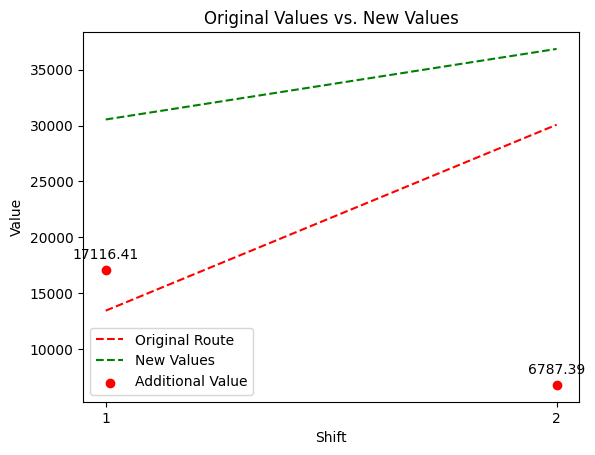

In [ ]:
import matplotlib.pyplot as plt

# Extract the original and new values from the route_list
original_values = [hour_value for hour_value in hour_value_list]
new_values = [route['Predicted'] for route in route_list]
additional_values = [route['Predicted'] - hour_value for route, hour_value in zip(route_list, hour_value_list)]

# Create a list of shifts based on shift_hours_list
shifts = []
for shift_hours in shift_hours_list:
    shifts.extend([i + 1 for i in range(shift_hours)])

# Make sure the shifts and original_values have the same length
shifts = shifts[:len(original_values)]

# Plot the original and new values
plt.plot(shifts, original_values, color='red', linestyle='--',label='Original Route')
plt.plot(shifts, new_values,color='green', linestyle='--', label='New Values')

# Plot the additional values as dots
plt.scatter(shifts, additional_values, c='red', label='Additional Value')

# Add annotations for the additional values
for shift, value, additional in zip(shifts, additional_values, additional_values):
    plt.annotate(f'{round(additional,2)}', xy=(shift, value), xytext=(shift, value+1000), ha='center')

# Set the x-axis tick locations
plt.xticks(shifts)

# Add labels and title to the plot
plt.xlabel('Shift')
plt.ylabel('Value')
plt.title('Original Values vs. New Values')

# Add a legend
plt.legend()

# Display the plot
plt.show()
